**Note:** This notebook requires [PRISM 4.7](https://www.prismmodelchecker.org/download.php) to be installed and
added to your PATH.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import tqdm
import warnings
from sklearn.manifold import TSNE
from typing import List
from markovsoccer.team_model import TeamModel
from markovsoccer.features import SideUsage, SideUsageShot, InwardsOutwardsPreference, SpeedOfPlay, LongBalls, \
    LongGoalKicks, SuccessfulCounterattackProbability, AbilityToCreateShootingOpportunities
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read Team Models

In [2]:
model_paths = [
    "../models/Belgium.prism",
    "../models/Brazil.prism",
    "../models/Croatia.prism",
    "../models/England.prism",
    "../models/France.prism",
    "../models/Russia.prism",
    "../models/Sweden.prism",
    "../models/Uruguay.prism"
]
models = list(map(TeamModel.read_from, model_paths))
team_names = list(map(lambda x: x.team_name, models))

## Construct Team Vectors

In [3]:
def construct_team_vector(model: TeamModel):
    side_usage = SideUsage.calculate(model)
    left, right, center = side_usage['left'], side_usage['right'], side_usage['center']
    side_usage_shot = SideUsageShot.calculate(model)
    left_shot, right_shot, center_shot = side_usage_shot['left'], side_usage_shot['right'], side_usage_shot['center']
    inwards_outwards_preference = InwardsOutwardsPreference.calculate(model)
    inwards_preference, outwards_preference = inwards_outwards_preference['inwards'], \
                                              inwards_outwards_preference['outwards']
    speed_of_play = SpeedOfPlay.calculate(model)
    long_balls_probability = LongBalls.calculate(model)
    long_goalkicks_probability = LongGoalKicks.calculate(model)
    counterattack_probability = SuccessfulCounterattackProbability.calculate(model)
    shooting_ability = AbilityToCreateShootingOpportunities.calculate(model)
    return np.array([
        left,
        right,
        center,
        left_shot,
        right_shot,
        center_shot,
        inwards_preference,
        outwards_preference,
        speed_of_play,
        long_balls_probability,
        long_goalkicks_probability,
        counterattack_probability,
        shooting_ability
    ])

In [4]:
# Ignore the RuntimeWarning: because data of only 5 to 7 matches is used, there is data scarcity in
# some rare areas of the pitch. This only has a minor influence on the results.
team_vectors = np.zeros((len(models), 13))
it_verbose = tqdm.tqdm(range(len(models)), desc="Constructing team vectors")
for i in it_verbose:
    model = models[i]
    team_vectors[i, :] = construct_team_vector(model)

Constructing team vectors:   0%|          | 0/8 [00:00<?, ?it/s]C:\Users\jeroe\PycharmProjects\MarkovSoccer\markovsoccer\dtmc.py:145: RuntimeWarning: invalid value encountered in double_scalars
  R_new[transient_state, absorbing_state_index] = self.R[transient_state, absorbing_state_index] / divisor
Constructing team vectors: 100%|██████████| 8/8 [00:13<00:00,  1.69s/it]


In [5]:
# normalize team vectors
normalized_team_vectors = scipy.stats.zscore(team_vectors, axis=0)
normalized_team_vectors

array([[-0.84134601, -0.36302675,  0.85737614, -0.05718713, -0.31085297,
         0.41412059, -1.46039784,  0.50702013,  1.22627093, -0.69517431,
        -1.02267256, -0.40123013,  1.11083375],
       [ 0.73249919, -1.37662022,  0.90437299,  0.79310097, -0.92858785,
         0.37041116,  0.39040338,  0.70982818,  0.99102787, -0.96769011,
        -1.57968179, -0.03847203,  1.87281851],
       [ 1.45253035, -0.08433578, -0.78670896,  1.73588036, -0.54456287,
        -0.92531288,  0.27472831, -0.60842415, -0.65741534, -0.51317432,
        -0.54523608, -0.23096698, -0.55827038],
       [ 0.26715184, -0.3879326 ,  0.21852015,  0.22416213, -0.07049423,
        -0.11928877,  1.54715415, -1.41965635,  0.84352696, -0.15052182,
        -0.34210856, -1.38184176, -0.45860146],
       [ 0.72555266,  0.90035332, -1.31214483,  0.44705612,  0.79502746,
        -1.32958384,  0.96877877, -1.62246441,  0.72376165, -0.03159164,
         0.39516911,  0.73293696,  0.58062329],
       [-0.64385297,  2.036280

## Visualize Similar Teams

t-SNE is a method for visualizing high-dimensional data in two or three dimensions. Similar data points are
visualized close to each other and dissimilar points are visualized far from each other. Note that the visualizations
 can differ across runs, but general trends stay equal.

In [6]:
def visualize_tsne(team_names: List[str], normalized_team_vectors: np.ndarray):
    tsne = TSNE(n_components=2, perplexity=5, n_iter=1000).fit_transform(normalized_team_vectors)
    df = pd.DataFrame(tsne, index=team_names, columns=['tsne1', 'tsne2'])
    sns.scatterplot(
        data=df,
        x='tsne1',
        y='tsne2',
    )
    for i in range(df.shape[0]):
        plt.text(x=df.tsne1[i] + 0.3, y=df.tsne2[i] + 0.3, s=df.index[i], fontdict=dict(color='black', size=10),
                 bbox=dict(alpha=0.25))
    plt.xlim(df.tsne1.min() * 1.2, df.tsne1.max() * 1.2)
    plt.ylim(df.tsne2.min() * 1.2, df.tsne2.max() * 1.2)
    plt.show()

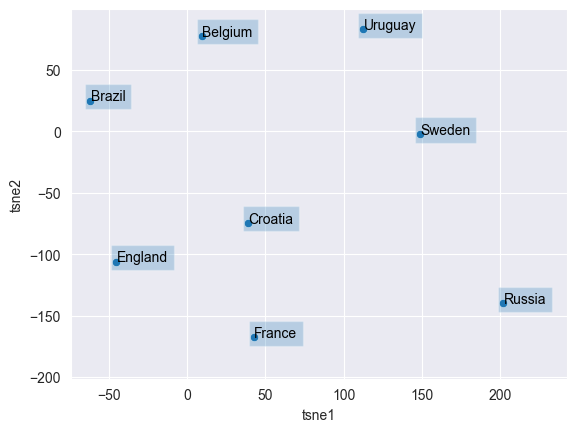

In [7]:
visualize_tsne(team_names, normalized_team_vectors)

As can be seen on the figure, the clash between France and Belgium in the semi-finals of the FIFA World Cup 2018 was
between two teams with a very dissimilar playing style. Indeed, France adopted a defensive playing style at the World
Cup while Belgium was much more offensive-minded. Brazil is a similar team to Belgium, also being known for their
offensive playing style. England and Croatia hold the middle ground between Belgium and France. Indeed, they weren't
particularly offensive or defensive-minded, but adopted a more balanced approach.